In [1]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
import pandas as pd
import glob
import os
import pypfopt as pyp
import quantstats as qs
import numpy as np
import matplotlib.pyplot as plt
import utils as u
%load_ext autoreload

In [2]:
minute_df_mid_usd = pd.read_csv('../cleaned_data/minute_data_mid_usd.csv', index_col='time_utc')
minute_df_mid_usd.index = pd.to_datetime(minute_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York')
minute_df_usd_price = (1/minute_df_mid_usd).fillna(method='ffill')
minute_df_usd_returns = minute_df_usd_price.pct_change()

# drop the first minute after the hour break
minute_df_usd_returns = minute_df_usd_returns[~((minute_df_usd_returns.index.hour ==18) & (minute_df_usd_returns.index.minute == 1))].dropna()
minute_df_usd_price_tr = minute_df_usd_price.loc[:'2022-04-29']
minute_df_usd_returns_tr = minute_df_usd_returns.loc[:'2022-04-29']



In [3]:
minute_df_usd_returns

,USD.EUR.SPOT,USD.JPY.SPOT,USD.CAD.SPOT,USD.AUD.SPOT,USD.GBP.SPOT,USD.NZD.SPOT,USD.MXN.SPOT,USD.NOK.SPOT,USD.SEK.SPOT,USD.TRY.SPOT
time_utc,,,,,,,,,,
2022-01-02 18:43:00-05:00,0.000031,-0.000004,-0.000186,0.000000,0.000000,0.000029,0.000054,0.000031,3.077599e-05,0.0000
2022-01-02 18:44:00-05:00,0.000000,0.000017,-0.000091,-0.000034,0.000000,-0.000073,0.000000,0.000020,0.000000e+00,0.0000
2022-01-02 18:45:00-05:00,-0.000084,-0.000078,-0.000075,-0.000096,-0.000004,-0.000066,0.000037,-0.000094,-6.409415e-05,0.0000
2022-01-02 18:46:00-05:00,-0.000022,-0.000069,0.000055,-0.000110,-0.000081,0.000000,-0.000007,-0.000012,-1.712416e-05,0.0000
2022-01-02 18:47:00-05:00,-0.000057,-0.000009,-0.000150,-0.000241,-0.000074,-0.000139,-0.000034,-0.000037,-5.715969e-05,0.0000
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 16:55:00-04:00,0.000000,-0.000018,0.000117,0.000000,-0.000021,0.000000,-0.000025,0.000000,2.565837e-04,0.0000
2022-06-30 16:56:00-04:00,0.000000,0.000000,0.000000,0.000000,-0.000021,0.000000,0.000323,0.000000,6.998227e-05,0.0000
2022-06-30 16:57:00-04:00,0.000000,-0.000055,-0.000078,0.000072,0.000082,0.000120,-0.000050,0.000000,0.000000e+00,0.0000


In [4]:
df_dict = {}
returns_dict = {}
for p in range(0,24):
    if p!=17:
        df_dict[p] = minute_df_usd_price_tr[minute_df_usd_price_tr.index.hour ==p]
        returns_dict[p] = minute_df_usd_returns_tr[minute_df_usd_returns_tr.index.hour ==p]

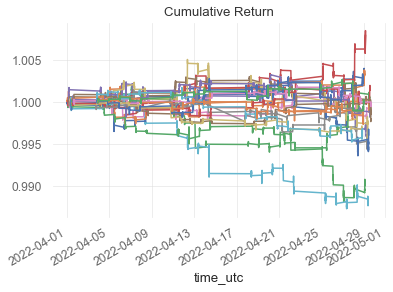

In [5]:
returns_static_dict = {}
cumul_returns_static_dict = {}
vol_static = []
port_static_dict ={}
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],None,len(returns_dict[x][:'2022-3-31']),static_start_date='2022-03-31',verbose=False,returns_data=True)
    port_static_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_static_dict[x] =bt[0]
    vol_static.append(bt[1])
    returns_static_dict[x] =bt[2]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23')])

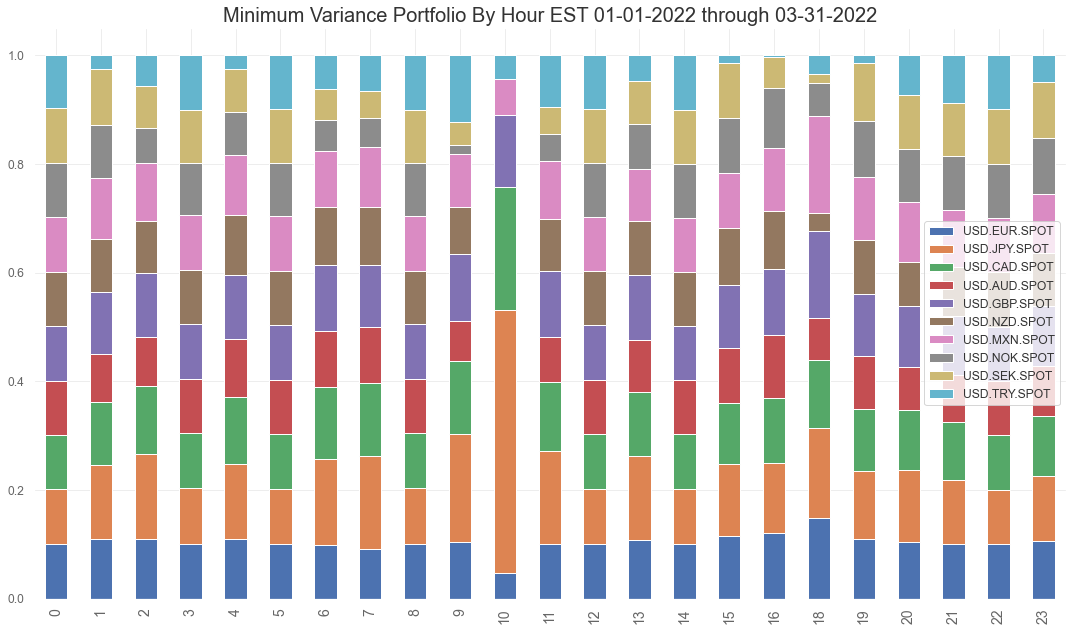

In [6]:
weight_df = pd.concat(port_static_dict, axis=0).droplevel(axis=0,level=0)
weight_df.index = weight_df.index.hour
ax = weight_df.plot.bar(stacked=True)
ax.legend(loc=5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.axes.set_title("Minimum Variance Portfolio By Hour EST 01-01-2022 through 03-31-2022", fontsize=20)
plt.xticks(fontsize=14)

([<matplotlib.axis.XTick at 0x1a4820f27c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

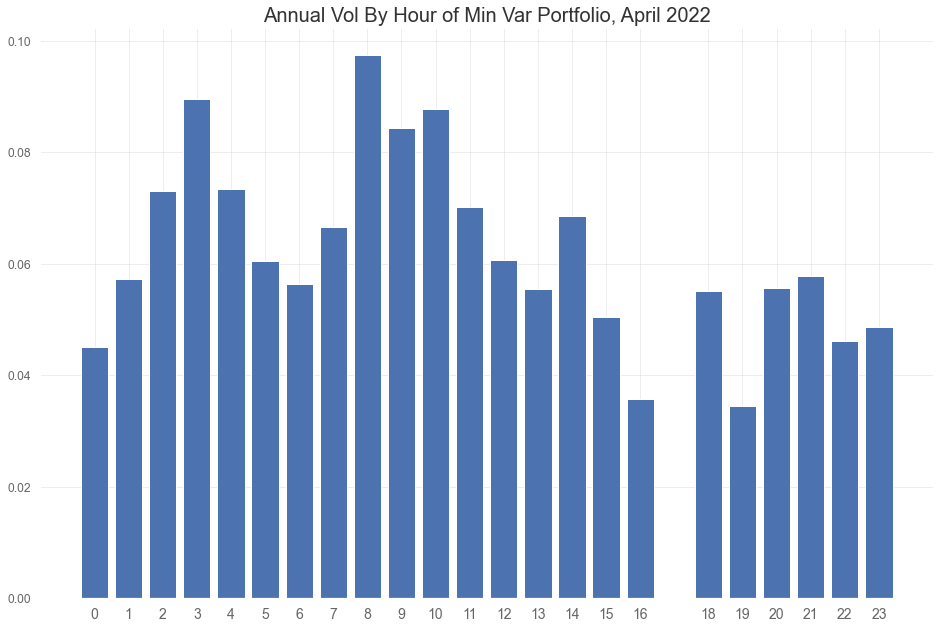

In [7]:
vol_static_ann= np.array(vol_static)*(60*23*252)**(1/2)
plt.bar(weight_df.index,vol_static_ann)
plt.title("Annual Vol By Hour of Min Var Portfolio, April 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)

### Rolling

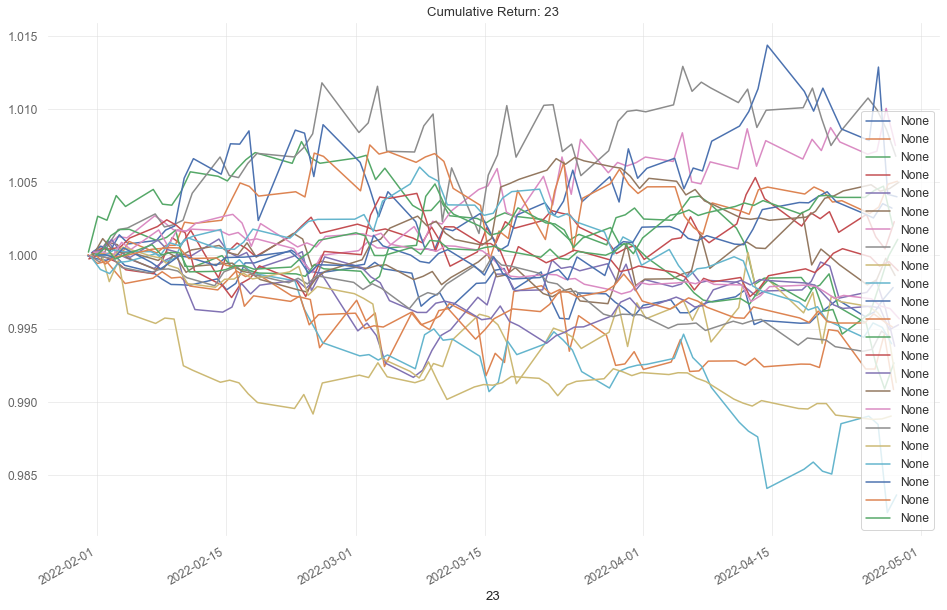

In [39]:
returns_rolling_dict = {}
cumul_returns_rolling_dict = {}
vol_rolling = []
port_rolling_dict ={}
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],60,len(returns_dict[x][:'2022-1-31']),static_start_date='2022-01-31',verbose=False,returns_data=True)
    port_rolling_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_rolling_dict[x] =bt[0]
    vol_rolling.append(bt[1])
    returns_rolling_dict[x] =bt[2]
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16, 10.5)

In [40]:
from copy import deepcopy

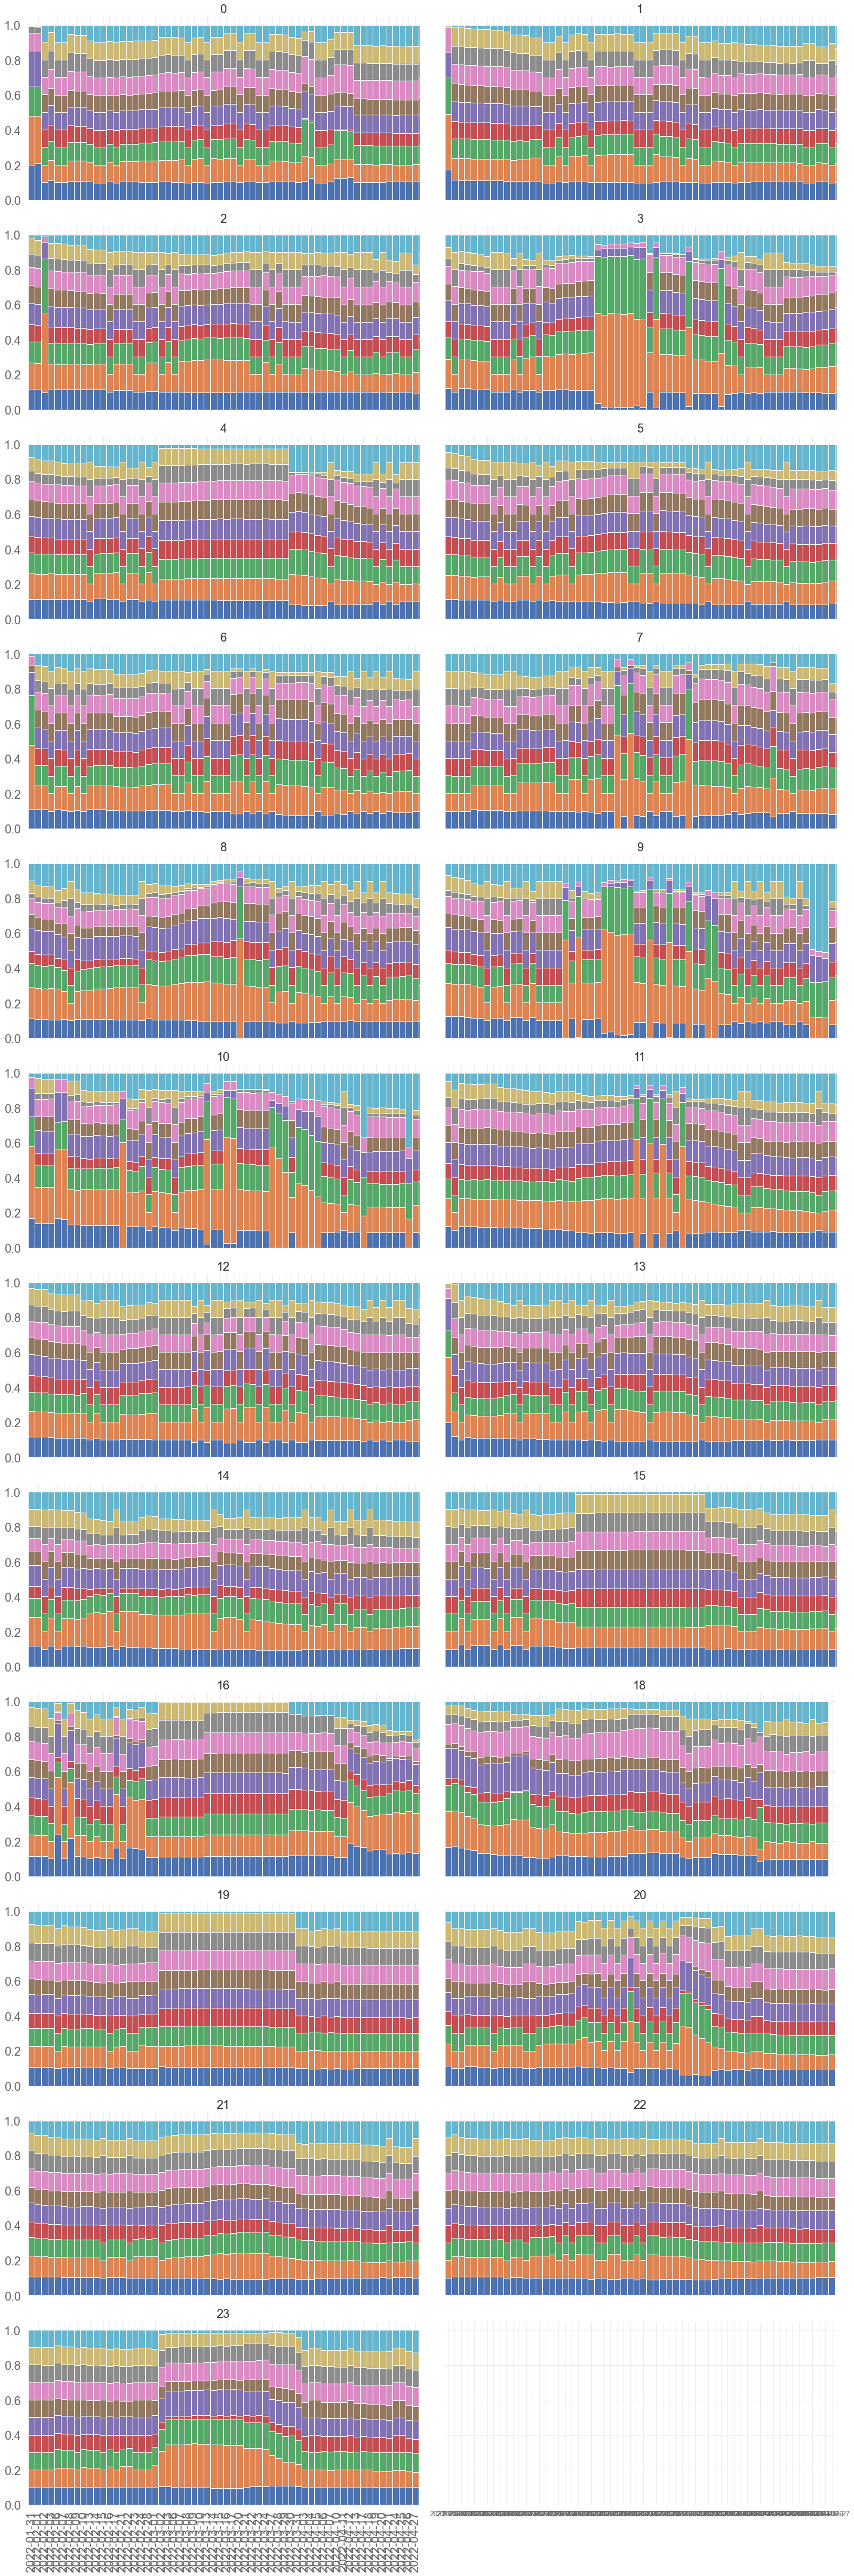

In [60]:
port_rolling_dict_g = deepcopy(port_rolling_dict)
fig, axarr = plt.subplots(int(len(port_rolling_dict_g.keys())/2+1),2, figsize=(20,60), sharex=True, sharey=True)
i=0
for x in port_rolling_dict.keys():
    port_rolling_dict_g[x].index = port_rolling_dict_g[x].index.date
    port_rolling_dict_g[x].plot.bar(ax=axarr[int(i/2)][i%2],stacked=True, legend=False, width=1.0,fontsize=20)
    axarr[int(i/2)][i%2].set_title(str(x), fontsize=20)
    i+=1
fig.tight_layout()

### Linear Combination of All Day Covariance and by the hour covariance
Find winning linear combination to reduce variance